In [37]:
import torch
from stochastic.processes.continuous import FractionalBrownianMotion
import torch.nn as nn
from torch import Tensor
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class fbm_dropout_2(nn.Module):

    def __init__(self, hurst: float, n_agents: int, max_epoch: int, grid_size: tuple, is_conv=False, show=False):

        super().__init__()
        
        # a list of fbm's for x coordinate of 
        self.agents_x = []
        self.agents_y = []
        self.colors = []
        self.n_agents = n_agents
        self.grid_size = grid_size
        self.is_conv = is_conv
        self.show = show
        for _ in range(n_agents):
            fbm_x = FractionalBrownianMotion(hurst, t=1)
            fbm_y = FractionalBrownianMotion(hurst, t=1)

            self.agents_x.append((fbm_x.sample(100 * max_epoch) + torch.rand((1,)).item()) % 1)
            self.agents_y.append((fbm_y.sample(100 * max_epoch) + torch.rand((1,)).item()) % 1)
            color = torch.rand((3,))
            color = (color[0].item(), color[1].item(), color[2].item())
            self.colors.append(color)
        
        self.grid = self.get_grid()

    def forward(self, input: Tensor, current_epoch) -> Tensor:
        '''
        given an input, return a dropped out output
        where the dropout probability of each neuron
        is determined by the fbm

        args:
            input: a Tensor with shape (batch_size, self.input_size)

        '''
        mask = self.get_mask(current_epoch)

        return torch.mul(input, mask)

    def get_mask(self, epoch: int) -> Tensor:

        mask = self.is_touching(epoch)

        return mask

    def get_grid(self):

        self.n_row = n_row = self.grid_size[1]
        self.n_col = n_col = self.grid_size[0]

        size_row = 1.0 / n_row
        size_col = 1.0 / n_col

        gap_y = size_row / 4
        gap_x = size_col / 4

        grid = {}
        for x in range(n_col):
            for y in range(n_row):
                x_low = (x * size_col) + gap_x
                y_low = (y * size_row) + gap_y
                x_high = x_low + 2 * gap_x
                y_high = y_low + 2 * gap_y
                grid[(x,y)] = ((x_low, x_high), (y_low, y_high))

        return grid

    def is_touching(self, epoch: int):
        
        def is_in(agent_x, agent_y, g):
            ((x_low, x_high), (y_low, y_high)) = g
            for x,y  in zip(agent_x, agent_y):
                if x_low <= x and x <= x_high and y_low <= y and y <= y_high:
                    return True
            return False

        is_touching = torch.ones(self.grid_size)

        t = epoch*100
        curr_agent_x = [agent_x[t:t+100] for agent_x in self.agents_x]
        curr_agent_y = [agent_y[t:t+100] for agent_y in self.agents_y]

        if self.show:
            fig, ax = plt.subplots()
            for i in range(self.n_agents):
                ax.scatter(curr_agent_x[i], curr_agent_y[i], s=1.0, color=self.colors[i])
            for x in range(self.n_col):
                for y in range(self.n_row):
                    ((x_low, x_high), (y_low, y_high)) = self.grid[(x,y)]
                    ax.add_patch(Rectangle((x_low, y_low), x_high - x_low, y_high - y_low,
                                           facecolor='red', zorder=0))
            ax.set_aspect('equal')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            plt.show()
        
        for i in range(self.n_col):
            for j in range(self.n_row):
                for x, y in zip(curr_agent_x, curr_agent_y):
                    if is_in(x, y, self.grid[(i,j)]):
                        is_touching[(i,j)] = 0
            
        is_touching = torch.rot90(is_touching)
        if self.is_conv:
            return is_touching
        return is_touching.reshape(-1)

In [40]:
dropout = fbm_dropout_2(0.9, 2, 10, (3,3), True, True)

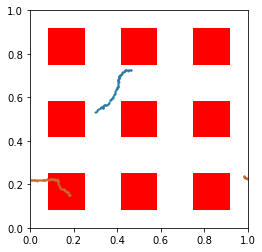

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [0., 1., 1.]])


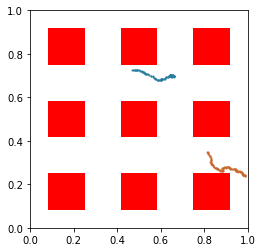

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


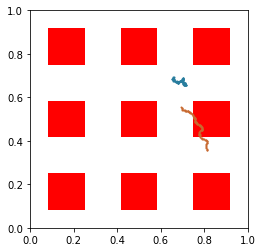

tensor([[1., 1., 1.],
        [1., 1., 0.],
        [1., 1., 1.]])


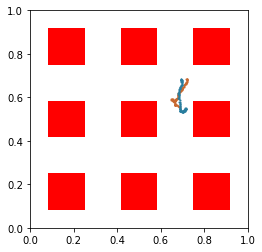

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


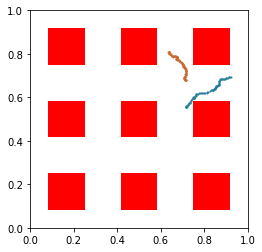

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


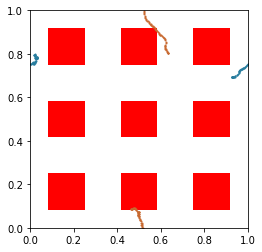

tensor([[1., 0., 1.],
        [1., 1., 1.],
        [1., 0., 1.]])


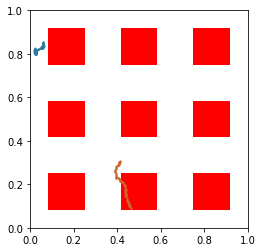

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 0., 1.]])


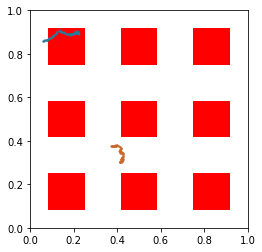

tensor([[0., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


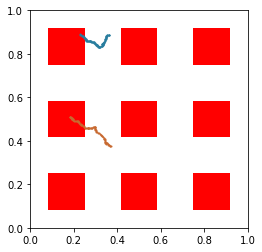

tensor([[0., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]])


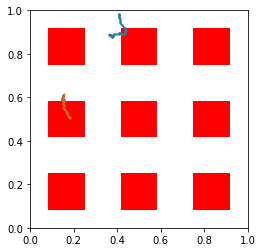

tensor([[1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 1.]])


In [41]:
for epoch in range(10):
    mask = dropout.get_mask(epoch)
    print(mask)